# 3D fuel mapping for forest fire risk assessment

### Purpose

The objetive of this tutorial is to explain the Experiment 2 of the GeoSpatial use case in the H2020 CloudButton project. The main goal of the project is to create a Serverless Data Analytics Platform that aims to “democratize big data” by overly simplifying the overall life cycle and programming model thanks to serverless technologies. The idea is to tap into stateless functions to enable radically-simpler, more user-friendly data processing systems. The CloudButton platform will seamlessly integrate a Serverless Compute Engine, a Mutable Shared Data Middleware, and new Serverless Cloud Programming Abstractions on top.

The seconed experiment is based in a high-resolution forest fuel mapping. We will generate a fuel map of the Valencian Community in Spain, which include protected areas, using remote sensing fusion techniques and following an object-based classification model. Segmentation and supervised classification of Sentinel-2 images and 3D LiDAR-derived metrics of shrub
and tree canopy structure of two dates (reference years) will be used as input data in spatial
fire risk modelling, that also benefits of high resolution elevation models and other topographic input variables. The expected result is a high-resolution forest fire risk map that is useful for decision-making in forest planning and management (a ten-fold increase in map accuracy and better land-cover discrimination). Also, we will make a performance
comparison assessment of results obtained through CloudButton toolkit and conventional software and computer facilities

### 1. Setup


#### 1.1. Set up docker

To work with all the libraries in a **jupyter notebook** we will run a **docker** built for the experiment. It is necesarry to download <a href="https://www.docker.com/products/docker-desktop">docker desktop</a>, once it is done, we download and run the image of the docker that its gonna be used.

> docker pull mavsonnen/jupy-notebook:geosv2<br>
> docker run mavsonnen/jupy-notebook:geosv2

A **local directory** can be connected to a docker container creating a volume using <i>-v option</i>, change <i>local_path</i>:

> docker run -p 8888:8888 -v E:/cloudbutton:/home/jovyan/work mavsonnen/jupy-notebook:geosv2




#### 1.2. Importing libraries

The following libraries are necessary:

In [490]:
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale,StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans 
from shapely.geometry import mapping
from IPython.display import Image
from IPython.core.display import HTML 
from shapely.geometry import mapping
import rasterio as rio
from sklearn.pipeline import Pipeline
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import lithops
import shapely
import shutil
import pickle
import joblib
import gdal
import earthpy as ep
import earthpy.spatial as es
import time
import glob
import ogr
import os
import io
import pdal
#import rioxarray as rxr
import xarray as xr
import json
from matplotlib.colors import ListedColormap, BoundaryNorm
import warnings
warnings.filterwarnings("ignore")

print("Libraries imported succesfully")

Libraries imported succesfully


#### 1.3. Configuration lithops

We have reached the serverless implementation thanks to the framework **lithops**.
All files that are going to run it will be on local.

![Image of Yaktocat](https://github.com/lithops-cloud/lithops/blob/master/docs/images/lithops_flat_cloud_1.png?raw=true)

Working with lithops require a configuration file like the one express below. More info can be found in the official **<a href="https://github.com/lithops-cloud/lithops">github</a> of Lithops**. 

 <i>
    config = { 'lithops' : {'storage_bucket' : 'BUCKET_NAME'},
    
           'ibm_cf':  {'endpoint': 'ENDPOINT',
                      'namespace': 'NAMESPACE',
                      'api_key': 'API_KEY'},
    
           'ibm_cos': {'region': 'REGION',
                      'api_key': 'API_KEY'}}

The **config** file with all the parameters is uploaded below

In [491]:
config_path = open("config.txt")
config_read = config_path.read()
config = json.loads(config_read)

#### 1.4. Downloading images

The LiDAR data has been obtained from the Spanish National Geographic Institute of the PNOA (National Plan of Aerial Orthophotography) <a href="http://centrodedescargas.cnig.es/CentroDescargas/catalogo.do?Serie=LIDAR">link</a>. 

1- Selecet LIDAR 2ª Cobertura (2015-Actualidad).

2- Select valencian community from top left.

3- Choose which data year we want to download. 

### 2. Dataset processing

#### 2.1 Remove noise data and create DEM (Digital Elevation Model)

The first step in Point cloud data is removing noise points. The filter used was the Radius Outlier Removal filter (ROR) due to its good results compared to other filters.


A Digital Elevation Model (DEM) or Digital Terrain Model (DTM) is a representation of the bare ground (bare earth) topographic surface of the Earth excluding trees, buildings, and any other surface objects. 

In this case we want to ignore any LiDAR classification values that may have already been calculated so that we can derive our own. In this example we apply a value of 0 (not classified) to the Classification dimension for every point.


The PDAL (Point Data Abstraction Library) is a very powerful tool for processing LiDAR point cloud data and very adept at extracting surface models based on point classification and filtering algorithms.

PDAL allows the composition of operations on point clouds into ‘pipelines’. These pipelines are written in the JSON format and define each step for the processing of the data in a sequence. This leads itself to highly customisable point cloud processing, that is repeatable and runs many steps in one execution of the program.



Define dem_extract function  that read lidar images (laz extension), then remove noise data, extract DEM and save the new image as tif extension.

#### 2.2  Remove noise data and Create DSM (Digital Surface Model)


Digital Surface Model (DSM) represents the top of the earth’s surface. It includes TREES, BUILDINGS and other objects that sit on the earth.

To Extract DSM we will write dsm_extract function that has pipeline composed for extracting the DSM from the cleaned LiDAR point cloud.

In this case we want to ignore any LiDAR classification values that may have already been calculated so that we can derive our own. In this example we apply a value of 0 (not classified) to the Classification dimension for every point.



Any time we have points classified as ground, we may wish to extract just these points, e.g., to create a digital terrain model (DTM). In this case, we use a range filter as shown.



Create neccesary folders to save lidars.Then, save lidar in temporary folder


#### 2.3  Create CHM (Canopy Height Model)

The height or residual distance between the ground and the top of the of objects above the ground. This includes the actual heights of trees, builds and any other objects on the earth’s surface. This CHM is created by subtracting the DTM from the DSM.


Once the DSM and DTM models have are computed, GDAL can be used to run a raster calculator to output the CHM.



## Topography characteristics

Topography Landscape topography has an impact on the environmental conditions, the amount of certain types  of  vegetation,  and  therefore,  has  a  direct  influence  upon  fire  propagation.  In  the following,  we  focus  on  the  aspect,  slope  and  elevation  that  are  input  variables  of  fire  spread models and that can be retrieved using LiDAR.  

a) Aspect: the aspect is the direction a slope is facing. The solar orientation generally determines the amount of heat provided by the Sun and therefore has high influence on  the  amount,  condition  and  type  of  fuels.  South-southwest  slopes  are  more  exposed  to sunlight  and  often  correspond  to  lighter  and  sparser  fuels,  higher  temperatures,  lower humidity  and  lower  fuel  moisture.  They  consequently  are  most  critical  in  terms  of  start  and spread of wildland fires. On the contrary, north-facing slopes are less subjected to fire activity than  south-facing  slopes.  They  are  more  shaded,  which  leads  to  heavier  fuels,  lower temperature, higher humidity and higher fuel moisture. North-facing vs south-facing slopes.  
 

b) Slope: it is the degree of incline of a hill side. The steeper  the slope, the faster  the  fire  spreads,  and  it  burns  more  rapidly uphill  than  downhill.  An explanation  for  these  two  phenomena  is  that  the  fuel  above  the  fire  is  brought  into  closer contact with the upward moving flames. Another concern about steep slopes is the possibility that burning materials roll down the hill and ignite the fuel below the main fire. A  surface  fire  is  primarily  influenced  by  the  amount  of  fuel  and  the  wind  speed,  but  a  fire starting near the bottom of a slope in normal daytime upslope wind conditions should spread faster and over a larger area than a fire starting near the top of the slope. 

In [592]:
# list the contents of ziad-cloudbutton bucket before doing any preprocessing 
fexec = lithops.FunctionExecutor(config = config, runtime = 'ziad06/imagecloud:pdal100', runtime_memory = 2048)
fexec.storage.list_keys('ziad-cloudbutton')


Lithops v2.2.3 init for IBM Cloud Functions - Namespace: ibm-cos_prueba - Region: us_east


['PNOA_2017_CLM-CAS_242-4422_ORT-CLA-IRC.laz',
 'PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.laz',
 'PNOA_2017_CLM-CAS_242-4424_ORT-CLA-IRC.laz',
 'PNOA_2017_CLM-CAS_242-4424_ORT-CLA-RGB.laz',
 'PNOA_2017_CLM-CAS_242-4426_ORT-CLA-IRC.laz',
 'PNOA_2017_CLM-CAS_242-4426_ORT-CLA-RGB.laz',
 'PNOA_2017_CLM-CAS_242-4428_ORT-CLA-IRC.laz',
 'PNOA_2017_CLM-CAS_242-4428_ORT-CLA-RGB.laz',
 'PNOA_2017_CLM-CAS_242-4430_ORT-CLA-IRC.laz',
 'PNOA_2017_CLM-CAS_242-4430_ORT-CLA-RGB.laz',
 'PNOA_2017_CLM-CAS_242-4432_ORT-CLA-IRC.laz',
 'PNOA_2017_CLM-CAS_242-4432_ORT-CLA-RGB.laz',
 'PNOA_2017_CLM-CAS_242-4434_ORT-CLA-IRC.laz',
 'PNOA_2017_CLM-CAS_242-4434_ORT-CLA-RGB.laz',
 'PNOA_2017_CLM-CAS_242-4436_ORT-CLA-IRC.laz',
 'PNOA_2017_CLM-CAS_242-4436_ORT-CLA-RGB.laz',
 'PNOA_2017_CLM-CAS_242-4438_ORT-CLA-IRC.laz',
 'PNOA_2017_CLM-CAS_242-4438_ORT-CLA-RGB.laz',
 'PNOA_2017_CLM-CAS_244-4428_ORT-CLA-IRC.laz',
 'PNOA_2017_CLM-CAS_244-4428_ORT-CLA-RGB.laz']

We create calculation function that receive lidar photo that exist in IBM cloud. Then,  the function does the steps that we explained it above (DEM, DSM, CHM, Aspect and Slope).

In [593]:
def calculation(obj, ibm_cos):
    
    # Define locations 
    key = obj.key
    bucket_name = 'ziad-cloudbutton'
    loc_dsm = 'dsm/'
    loc_dem = 'dem/'
    loc_chm = 'chm/'
    loc_aspect = 'aspect/'
    loc_slope = 'slope/'
    input_folder = "input_folder/"
    
    #-----------------------------------------------------------------------------------
    # Create dsm, dem, chm, slope, aspect, and input folders to save the photos after doing process

    if not os.path.exists(input_folder):
        os.mkdir(input_folder)
      
    if not os.path.exists(loc_dsm):
        os.mkdir(loc_dsm)
    
    if not os.path.exists(loc_dem):
        os.mkdir(loc_dem)
    
    if not os.path.exists(loc_chm):
        os.mkdir(loc_chm)
        
    if not os.path.exists(loc_aspect):
        os.mkdir(loc_aspect)
        
    if not os.path.exists(loc_slope):
        os.mkdir(loc_slope)
        
   #-----------------------------------------------------------------------------------
   # Delete any file in dsm, dem, chm, slope, aspect, and input folders

    files = os.listdir(loc_dsm)
    if len(files) > 0:
        for file in files:
            file_path = os.path.join(loc_dsm, file)
            os.unlink(file_path)
            
    files = os.listdir(loc_dem)
    if len(files) > 0:
        for file in files:
            file_path = os.path.join(loc_dem, file)
            os.unlink(file_path)
            
    files = os.listdir(loc_chm)
    if len(files) > 0:
        for file in files:
            file_path = os.path.join(loc_chm, file)
            os.unlink(file_path)
            
    files = os.listdir(loc_slope)
    if len(files) > 0:
        for file in files:
            file_path = os.path.join(loc_slope, file)
            os.unlink(file_path)
            
    files = os.listdir(loc_aspect)
    if len(files) > 0:
        for file in files:
            file_path = os.path.join(loc_aspect, file)
            os.unlink(file_path)
            
            
    files = os.listdir(input_folder)
    if len(files) > 0:
        for file in files:
            file_path = os.path.join(input_folder, file)
            os.unlink(file_path)
    # -----------------------------------------------------------------------------------      
    # We interested just in laz photos
    if '.laz' in key:
       


        # Read data stream of object
        data = obj.data_stream.read()   
        
        # Save data into file 
        s_file = input_folder + key
        with open(s_file, 'wb') as fname:
            fname.write(data)

        # -----------------------------------------------------------------------------------  
        # define variables name 
       
        lasfile = fname.name
        filez =key.split(".")[0]
        outputfile_dsm = loc_dsm +  f"dsm_{filez}.tif"
        outputfile_dem = loc_dem +  f"dem_{filez}.tif"

        inputfiles_dem = f"dem/dem_{filez}.tif"
        inputfiles_dsm = f"dsm/dsm_{filez}.tif"
        outputfile_chm = f"chm/chm_{filez}.tif"
        outputfile_aspect = f"aspect/aspect_{filez}.tif"
        outputfile_slope =  f"slope/slope_{filez}.tif"
       
        # -----------------------------------------------------------------------------------  
        # calculate DSM
        creating_json = {
                "pipeline": [
                {
                        "type": "readers.las",
                        "filename": f"{lasfile}",
                        "spatialreference": "EPSG:25830"
                },
                {

                        "type":"filters.reprojection",

                        "in_srs":"EPSG:25830",

                        "out_srs":"EPSG:25830"

                },
                {
                        "type":"filters.outlier",
                        "method":"radius",
                        "radius":1.0,
                        "min_k":4
                },
                {
                        "type":"filters.range",
                        "limits":"Classification![7:7]"  # Classification equals 2 (corresponding to noise points in LAS).
                },
                {
                        "type":"filters.range",
                        "limits":"returnnumber[1:1]"

                },


                {
                        "type": "writers.gdal",
                        "gdaldriver": "GTiff",
                        "nodata": "-9999",
                        "output_type": "max",
                        "resolution": 1, 
                        "filename": f"{outputfile_dsm}"
                }
                
                ]
        }
        consulta = json.dumps(creating_json, indent = 4)
        pipeline = pdal.Pipeline(consulta)
        pipeline.validate()  # Check if json options are good
        pipeline.loglevel = 8
        count = pipeline.execute()    
        
        # calcualte DEM
        creating_json = {
                    "pipeline": [

                    {
                            "type": "readers.las",
                            "filename": f"{lasfile}",
                            "spatialreference": "EPSG:25830"
                    },


                    {
                            "type":"filters.reprojection",
                            "in_srs":"EPSG:25830",
                            "out_srs":"EPSG:25830"
                    },


                    {
                          "type":"filters.assign",
                          "assignment":"Classification[:]=0"
                    },


                     {
                              "type":"filters.elm"
                    },

                    {
                            "type":"filters.outlier",
                            "method":"radius",
                            "radius":1.0,
                            "min_k":4
                    },
                    {

                          "type":"filters.smrf",
                          "ignore":"Classification[7:7]",
                          "slope":0.2,
                          "window":16,
                          "threshold":0.45,
                          "scalar":1.2
                    },

                    {
                            "type": "filters.range",
                            "limits": "Classification[2:2]", # Classification equals 2 (corresponding to ground in LAS).



                    },


                    {
                            "type": "writers.gdal",
                            "gdaldriver": "GTiff",
                            "nodata": "-9999",
                            "output_type": "max",
                            "resolution": 1, 
                            "filename": f"{outputfile_dem}"
                    }

                    ]
            }
        consulta = json.dumps(creating_json, indent = 4)
        pipeline = pdal.Pipeline(consulta)
        pipeline.validate()  # Check if json options are good
        pipeline.loglevel = 8
        count = pipeline.execute()  
        
        # calculate CHM
        command = 'gdal_calc.py -A {0} -B {1}   --calc="B-A" --outfile {2}'.format(inputfiles_dem,inputfiles_dsm, outputfile_chm)
        os.system(command)
        
        # calculate aspect
        command = 'gdaldem  aspect {0}  {1} -compute_edges'.format(inputfiles_dem,outputfile_aspect)
        os.system(command)
        
        # calculate slope
        command = 'gdaldem  slope {0}  {1} -compute_edges'.format(inputfiles_dem,outputfile_slope)
        os.system(command)
   
        
        
        
        #Upload files into COS
        
        #Upload DEM
        for r, d, f in os.walk(loc_dem): # r=root, d=directories, f = files
            for file in f:
                ibm_cos.upload_file(Filename = loc_dem + file, Bucket = bucket_name, Key =  loc_dem + file)
                
        #Upload DSM
        for r, d, f in os.walk(loc_dsm): # r=root, d=directories, f = files
            for file in f:
                ibm_cos.upload_file(Filename = loc_dsm + file, Bucket = bucket_name, Key = loc_dsm + file)
                
        #Upload CHM
        for r, d, f in os.walk(loc_chm): # r=root, d=directories, f = files
            for file in f:
                ibm_cos.upload_file(Filename = loc_chm + file, Bucket = bucket_name, Key = loc_chm + file)
            
        #Upload slope
        for r, d, f in os.walk(loc_slope): # r=root, d=directories, f = files
            for file in f:
                ibm_cos.upload_file(Filename = loc_slope + file, Bucket = bucket_name, Key = loc_slope + file)
                
        #Upload aspect
        for r, d, f in os.walk(loc_aspect): # r=root, d=directories, f = files
            for file in f:
                ibm_cos.upload_file(Filename = loc_aspect + file, Bucket = bucket_name, Key = loc_aspect + file)
                
        # the calculation function return done if and only if the obj is laz file         
        return 'Done!'
    else:
        # if the object isnt laz file return fail
        return 'Fail!'
    
data_location = 'ziad-cloudbutton'



Apply preprocessing steps using Lithops

In [602]:
fexec = lithops.FunctionExecutor(config = config, runtime = 'ziad06/imagecloud:pdal100', runtime_memory = 4096)
fexec.map(calculation, data_location)
fexec.wait()

Lithops v2.2.3 init for IBM Cloud Functions - Namespace: ibm-cos_prueba - Region: us_east
ExecutorID 9854f3/193 | JobID M000 - Selected Runtime: ziad06/imagecloud:pdal100 - 4096MB 
ExecutorID 9854f3/193 | JobID M000 - Uploading function and data - Total: 597.6KiB
ExecutorID 9854f3/193 | JobID M000 - Starting function invocation: calculation() - Total: 20 activations
ExecutorID 9854f3/193 - Waiting for functions to complete...


([<lithops.future.ResponseFuture at 0x7ff09c230550>,
 [])

In [603]:
# list the contents of ziad-cloudbutton bucket after doing preprocessing steps
fexec.storage.list_keys('ziad-cloudbutton')


['PNOA_2017_CLM-CAS_242-4422_ORT-CLA-IRC.laz',
 'PNOA_2017_CLM-CAS_242-4422_ORT-CLA-RGB.laz',
 'PNOA_2017_CLM-CAS_242-4424_ORT-CLA-IRC.laz',
 'PNOA_2017_CLM-CAS_242-4424_ORT-CLA-RGB.laz',
 'PNOA_2017_CLM-CAS_242-4426_ORT-CLA-IRC.laz',
 'PNOA_2017_CLM-CAS_242-4426_ORT-CLA-RGB.laz',
 'PNOA_2017_CLM-CAS_242-4428_ORT-CLA-IRC.laz',
 'PNOA_2017_CLM-CAS_242-4428_ORT-CLA-RGB.laz',
 'PNOA_2017_CLM-CAS_242-4430_ORT-CLA-IRC.laz',
 'PNOA_2017_CLM-CAS_242-4430_ORT-CLA-RGB.laz',
 'PNOA_2017_CLM-CAS_242-4432_ORT-CLA-IRC.laz',
 'PNOA_2017_CLM-CAS_242-4432_ORT-CLA-RGB.laz',
 'PNOA_2017_CLM-CAS_242-4434_ORT-CLA-IRC.laz',
 'PNOA_2017_CLM-CAS_242-4434_ORT-CLA-RGB.laz',
 'PNOA_2017_CLM-CAS_242-4436_ORT-CLA-IRC.laz',
 'PNOA_2017_CLM-CAS_242-4436_ORT-CLA-RGB.laz',
 'PNOA_2017_CLM-CAS_242-4438_ORT-CLA-IRC.laz',
 'PNOA_2017_CLM-CAS_242-4438_ORT-CLA-RGB.laz',
 'PNOA_2017_CLM-CAS_244-4428_ORT-CLA-IRC.laz',
 'PNOA_2017_CLM-CAS_244-4428_ORT-CLA-RGB.laz',
 'aspect/aspect_PNOA_2017_CLM-CAS_242-4422_ORT-CLA-IRC.tif',

###  Machine Learning - KMeans


We use clustering to group pixels together based on their similarities because we have no information about which ones belong together.

Prepare the names of data that we would train it.

In [167]:
data= []
for file in os.listdir("tmp"):
                if "laz" in file:
                        # Define input and output files

                        filez = file.split(".")[0]
                        input_dem = f"dem1/dem_{filez}.tif"
                        input_slop = f"slope1/slope_{filez}.tif"
                        input_aspect = f"aspect1/aspect_{filez}.tif"
                        raster_fns = [input_dem,input_slop,input_aspect]   
                        data.append(raster_fns)
       


In [168]:
# Define number of images we want to use it as training data.
num_of_img = 20
# Define X_train array to save training data in it. 
X_train = np.array([], dtype=np.int8).reshape(0,3) # pixels

# For loop read 20 images, after that saves the pixels in X_train
for i in range(num_of_img):

    band_list = []
    for image in data[i]:
        with rio.open(image, 'r') as src:
            band = src.read(1)
            band = np.nan_to_num(band)
            band_list.append(band)
    bands_stack = np.dstack(band_list)
    width, height, depth = bands_stack.shape
    model_input = bands_stack.reshape(width * height, depth)
    X_train = np.vstack((X_train,model_input))
    


We have approximately 76 million training patterns.

In [170]:
# Train data size
X_train.shape

(76468408, 3)

In [173]:
no_of_ranges =  np.arange(3, 11, 1)
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}
models = []
predicted = []
inertia_vals = []
s_scores = []
for n_clust in no_of_ranges:
    kmeans = KMeans(n_clusters=n_clust,**kmeans_kwargs)
    y_pred =kmeans.fit_predict(X_train)

    # Append model
    models.append(kmeans)

    # Calculate metrics
    s_scores.append(silhouette_score(X_train, y_pred, sample_size=1000))
    #inertia_vals.append(pipe.inertia_)
    inertia_vals.append(kmeans.inertia_)

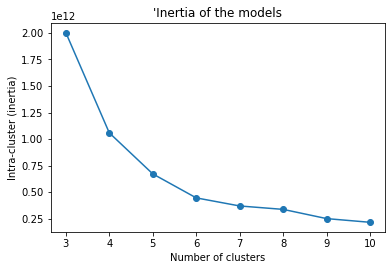

In [174]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(no_of_ranges, inertia_vals, marker='o')
ax.set_title("'Inertia of the models")
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Intra-cluster (inertia)');


Text(0.5, 0, 'Number of clusters')

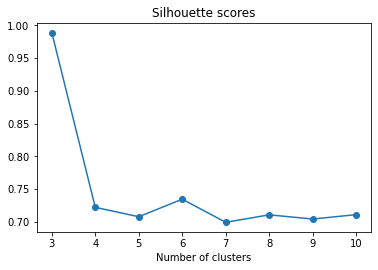

In [175]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(no_of_ranges, s_scores, marker='o')
ax.set_title("Silhouette scores")
ax.set_xlabel('Number of clusters')


The number of clusters (k) is the most important hyperparameter in K-Means clustering. So to find the optimal value of k we apply Elbow method and Silhouette method.

Elbow method finds the optimal number of clusters,  then the “elbow” (the point of inflection on the curve) is a good indication that the underlying model fits best at that point. The first graph indiactes the number 6 is the point of inflection on the curve.

The second graph reprsents Silhouette score. The range of the Silhouette value is between +1 and -1. A high value is desirable and indicates that the point is placed in the correct cluster. The second graph indiactes the number 6 has a high value.  


We can notice the number of clusters 6 is matching in both methods.

Now, we train the model another time using the value 6 as number of clusters.

In [176]:
kmeans = KMeans(n_clusters=5,**kmeans_kwargs)
y_pred =kmeans.fit_predict(X_train)



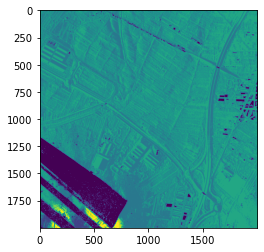

In [183]:
name = 'PNOA_2017_CLM-CAS_246-4450_ORT-CLA-IRC.tif'
aspect = 'aspect/aspect_'+name
slop = 'slop/slop_'+name
dem = 'dem/dem_'+name
raster_fns = [aspect,slop,dem]
band_list = []
for image in raster_fns:
    with rio.open(image, 'r') as src:
        band = src.read(1)
        band = np.nan_to_num(band)
        band_list.append(band)
bands_stack = np.dstack(band_list)
width, height, depth = bands_stack.shape
model_input = bands_stack.reshape(width * height, depth)
#model_input_scaled = scale(model_input)
#model_input_scaled = scaler.transform(model_input)
y_pred = kmeans.predict(model_input)
quantized_raster = np.reshape(y_pred, (width, height))
plt.imshow(quantized_raster)


###  Export and import  trained model 

Save the **Machine Learning model** based in KMeans through <i>joblib</i> and import it. By doing so we will be able to upload it to IBM_COS. 


In [178]:
tmp = '/home/jovyan/work/2nd experiment/' 

model = kmeans
name_model = 'kmeans.sav' 
joblib.dump(model, tmp +  name_model)

print("Trained model saved")

Trained model saved


In [179]:
loaded_model = joblib.load(tmp +  name_model)


print("Train model imported")

Train model imported


# Serverless Implementation - Lithops

We have reached the serverless implementation thanks to the framework **lithops**. The model which was trained before will be used to do clustring.



In [180]:
def map_classification(aspect,slop,dem):
    raster_fns = [aspect,slop,dem]
    band_list = []
    for image in raster_fns:
        with rio.open(image, 'r') as src:
            band = src.read(1)
            band = np.nan_to_num(band)
            band_list.append(band)
    bands_stack = np.dstack(band_list)
    width, height, depth = bands_stack.shape
    model_input = bands_stack.reshape(width * height, depth)




    loaded_model = joblib.load(tmp +  name_model)

    prediction = loaded_model.predict(model_input)  
    return  prediction




In [181]:
name = 'PNOA_2017_CLM-CAS_244-4452_ORT-CLA-IRC.tif'
aspect = 'aspect/aspect_'+name
slop = 'slop/slop_'+name
dem = 'dem/dem_'+name


Lithops v2.2.3 init for Localhost
ExecutorID 80c856/73 | JobID A000 - Selected Runtime: python3 
ExecutorID 80c856/73 | JobID A000 - Uploading function and data - Total: 1.3KiB
ExecutorID 80c856/73 | JobID A000 - map_classification() Invocation done - Total: 1 activations
ExecutorID 80c856/73 - Getting results...



ExecutorID 80c856/73 - Cleaning temporary data


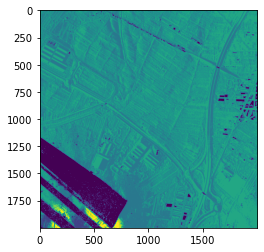

In [184]:
lt=lithops.FunctionExecutor(mode='localhost')
lt.call_async(map_classification,[aspect,slop,dem])
results = lt.get_result()
quantized_raster = np.reshape(results, (width, height))
plt.imshow(quantized_raster)


## Upload and prepare dataset in IBM Cloud

This code show us all Lidars that exist in the cloud ( ibm-cos-prueba bucket) and create list of lists. Each list contains 3 lidars names (DEM, Aspect and Slop).

In [198]:
# List Laz images that already stored in the cloud
lt=lithops.FunctionExecutor(config=config)

data= []
for file in lt.storage.list_keys('ibm-cos-prueba'):
                if "laz" in file:
                        # Define input and output files
                       
                        filez = file.split(".")[0]
                        input_dem = f"dem/dem_{filez}.tif"
                        input_slop = f"slop/slop_{filez}.tif"
                        input_aspect = f"aspect/aspect_{filez}.tif"
                        raster_fns = [input_dem,input_slop,input_aspect]   
                        data.append(raster_fns)
                

Lithops v2.2.3 init for IBM Cloud Functions - Namespace: ibm-cos_prueba - Region: us_east


Upload lidars (DEM, Aspect and Slop) to IBM cloud (ibm-cos-prueba bucket) using Lithops

In [199]:
for image in data:
    for lidar in range(len(image)):
        raster = rio.open(image[lidar]).read()
        bufImage  = io.BytesIO()
        joblib.dump(raster, bufImage)
        bufImage.seek(0)  # Without this line it fails
        lt.storage.put_object('ibm-cos-prueba', key= '%s'%(image[lidar]),data= bufImage)

   

Prepare training dataset that exist in IBM cloud, we get this data by using Lithops

In [200]:
# Define number of images we want to use it as training data.
num_of_img = 20
# Define X_train array to save training data in it. 
X_train = np.array([], dtype=np.int8).reshape(0,3) # pixels

# For loop read 20 images, after that saves the pixels in X_train
for i in range(num_of_img):

    band_list = []
    for image in data[i]:
        get_raster = lt.storage.get_object('ibm-cos-prueba', image)
        load_raster=joblib.load(io.BytesIO(get_raster))[0] 
        band = np.nan_to_num(load_raster)
        band_list.append(band)
    bands_stack = np.dstack(band_list)
    width, height, depth = bands_stack.shape
    model_input = bands_stack.reshape(width * height, depth)
    X_train = np.vstack((X_train,model_input))


In [201]:
len(X_train)

76468408

In [202]:
no_of_ranges =  np.arange(3, 11, 1)
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}
models = []
predicted = []
inertia_vals = []
s_scores = []
for n_clust in no_of_ranges:
    kmeans = KMeans(n_clusters=n_clust,**kmeans_kwargs)
    y_pred =kmeans.fit_predict(X_train)

    # Append model
    models.append(kmeans)

    # Calculate metrics
    s_scores.append(silhouette_score(X_train, y_pred, sample_size=1000))
    #inertia_vals.append(pipe.inertia_)
    inertia_vals.append(kmeans.inertia_)

Train the model

In [208]:
kmeans = KMeans(n_clusters=5,**kmeans_kwargs)
y_pred =kmeans.fit_predict(X_train)



Upload the trained model to IBM cloud bucket

In [209]:
model = kmeans
bufmodel  = io.BytesIO()
joblib.dump(model, bufmodel)
bufmodel.seek(0)  # Without this line it fails
lt.storage.put_object('ibm-cos-prueba', key= 'trained_model/kmeans.sav',data= bufmodel)

True

Names of data we want to predict

In [210]:
name = 'PNOA_2017_CLM-CAS_244-4452_ORT-CLA-RGB.tif'
aspect = 'aspect/aspect_'+name
slop = 'slop/slop_'+name
dem = 'dem/dem_'+name

Load kmeans model

In [211]:
get_model = lt.storage.get_object('ibm-cos-prueba', 'trained_model/kmeans.sav')
loaded_model = joblib.load(io.BytesIO(get_model)) 
loaded_model

KMeans(init='random', n_clusters=5, random_state=42)

Predict new data

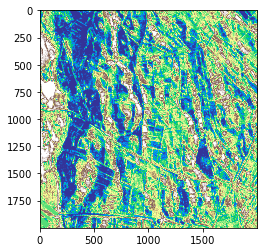

In [212]:
band_list = []
data = [aspect,slop,dem]
for image in data:
    get_raster = lt.storage.get_object('ibm-cos-prueba', image)
    load_raster=joblib.load(io.BytesIO(get_raster))[0] 
    band = np.nan_to_num(load_raster)
    band_list.append(band)
bands_stack = np.dstack(band_list)
width, height, depth = bands_stack.shape
model_input = bands_stack.reshape(width * height, depth)
prediction = loaded_model.predict(model_input)  
results = np.reshape(prediction, (width, height))
plt.imshow(results, cmap="terrain")